In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, average_precision_score, confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Set random seed
torch.manual_seed(0)
np.random.seed(0)

Using device: cuda


In [2]:
df = pd.read_csv('/content/train.csv')
df = df.dropna()
df = df[df['Age'] >= 0].reset_index(drop=True)

In [3]:
# Date features
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'], errors='coerce')
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'], errors='coerce')
df['waiting_days'] = ((df['AppointmentDay'] - df['ScheduledDay']).dt.days) + 1
df['appointment_weekday'] = df['AppointmentDay'].dt.weekday

# Binary and categorical features
df['No-show'] = df['No-show'].map({'No': 0, 'Yes': 1})
df['SMS_received'] = df['SMS_received'].astype(int)
df['Scholarship'] = df['Scholarship'].astype(int)
df = pd.get_dummies(df, columns=['Gender'], drop_first=True)
df['Gender_M'] = df['Gender_M'].astype(int)
df['Neighbourhood_encoded'], _ = pd.factorize(df['Neighbourhood'])

# Remove outliers
df = df[df['Handcap'] <= 1]

# Historical behavior features
df['num_prev_appts'] = df.groupby('PatientId').cumcount() + 1
df['missed_before'] = df.groupby('PatientId')['No-show'].transform(lambda x: x.shift().cumsum()).fillna(0)
df['missed_before'] = df['missed_before'].astype(int)
df['prev_no_show_rate'] = df['missed_before'] / df['num_prev_appts']

# Feature scaling
for col in ['Age', 'waiting_days', 'Neighbourhood_encoded', 'num_prev_appts', 'appointment_weekday']:
    df[col + '_scaled'] = (df[col] - df[col].mean()) / df[col].std()

# Final feature list
features = ['Age_scaled', 'Scholarship', 'Hipertension', 'Diabetes',
            'Alcoholism', 'Handcap', 'SMS_received', 'waiting_days_scaled',
            'appointment_weekday_scaled', 'Gender_M', 'Neighbourhood_encoded_scaled',
            'prev_no_show_rate', 'num_prev_appts_scaled']

In [17]:
X = df[features].values.astype(np.float32)
y = df['No-show'].values.astype(np.int64)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

In [18]:
class ANN(nn.Module):
    def __init__(self, input_dim):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)  # Binary classification (2 classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [19]:
# Initialize model, loss, and optimizer
model = ANN(X_train.shape[1]).to(device)
pos_weight = torch.tensor([(len(y_train) - sum(y_train)) / sum(y_train)], dtype=torch.float32).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
epochs = 30
batch_size = 64

for epoch in range(epochs):
    permutation = torch.randperm(X_train_tensor.size(0))
    for i in range(0, X_train_tensor.size(0), batch_size):
        indices = permutation[i:i+batch_size]
        batch_x, batch_y = X_train_tensor[indices], y_train_tensor[indices]

        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y.unsqueeze(1))
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        logits = model(X_train_tensor)
        probs = torch.sigmoid(logits)
        preds = (probs >= 0.5).int()
        acc = (preds.squeeze() == y_train_tensor).float().mean().item()
        f1 = f1_score(y_train_tensor.cpu(), preds.cpu())
        print(f"Epoch {epoch+1} - Loss: {loss.item():.4f}, Accuracy: {acc:.4f}, F1 Score: {f1:.4f}")

Epoch 1 - Loss: 0.9677, Accuracy: 0.5935, F1 Score: 0.4434
Epoch 2 - Loss: 0.9089, Accuracy: 0.5867, F1 Score: 0.4453
Epoch 3 - Loss: 1.2132, Accuracy: 0.5444, F1 Score: 0.4376
Epoch 4 - Loss: 0.5333, Accuracy: 0.6251, F1 Score: 0.4512
Epoch 5 - Loss: 0.6652, Accuracy: 0.5685, F1 Score: 0.4468
Epoch 6 - Loss: 0.7157, Accuracy: 0.6048, F1 Score: 0.4521
Epoch 7 - Loss: 0.6567, Accuracy: 0.5804, F1 Score: 0.4497
Epoch 8 - Loss: 0.6661, Accuracy: 0.5944, F1 Score: 0.4527
Epoch 9 - Loss: 0.4169, Accuracy: 0.5864, F1 Score: 0.4530
Epoch 10 - Loss: 0.6427, Accuracy: 0.6179, F1 Score: 0.4559
Epoch 11 - Loss: 1.7865, Accuracy: 0.6000, F1 Score: 0.4546
Epoch 12 - Loss: 0.4769, Accuracy: 0.6072, F1 Score: 0.4564
Epoch 13 - Loss: 0.6601, Accuracy: 0.6096, F1 Score: 0.4587
Epoch 14 - Loss: 0.1287, Accuracy: 0.6096, F1 Score: 0.4563
Epoch 15 - Loss: 0.8830, Accuracy: 0.6053, F1 Score: 0.4574
Epoch 16 - Loss: 1.1624, Accuracy: 0.5938, F1 Score: 0.4550
Epoch 17 - Loss: 0.7596, Accuracy: 0.5972, F1 Sco

In [23]:
# Evaluate on test data
model.eval()
with torch.no_grad():
    logits = model(X_test_tensor)
    probs = torch.sigmoid(logits)
    preds = (probs >= 0.5).int()
    f1 = f1_score(y_test_tensor.cpu(), preds.cpu())
    acc = (preds.squeeze() == y_test_tensor).float().mean().item()
    y_true = y_test_tensor.int().cpu().numpy()
    preds = (probs >= 0.5).int().squeeze().cpu().numpy()
    cm = confusion_matrix(y_true, preds)

print(f"\nTest Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"PR-AUC: {pr_auc:.4f}")
print("Confusion Matrix:")
print(cm)


Test Accuracy: 0.6046
F1 Score: 0.4487
PR-AUC: 0.3706
Confusion Matrix:
[[9791 7819]
 [ 906 3550]]


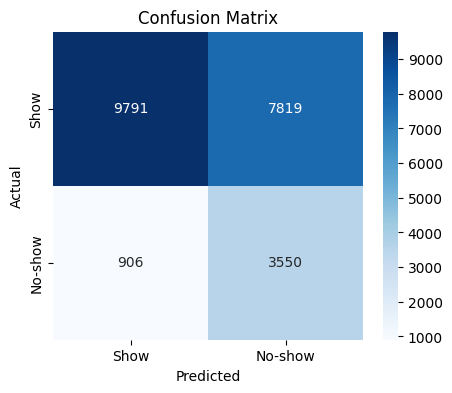

In [24]:
# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Show', 'No-show'], yticklabels=['Show', 'No-show'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
